## Step 1. Getting Started with Apache Spark (within Docker)

### Step 1.1 Initializing a Connection to Spark

We'll open a connection to Spark as follows.

In [1]:
import numpy as np
import pandas as pd

import time
import networkx as nx
import warnings

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

import os

spark = SparkSession.builder.appName('Graphs-HW2').getOrCreate()

### Step 1.2 Download data

The following code retrieves the Yelp dataset in a zipfile and decompresses it.

In [2]:
import zipfile
import urllib.request
import shutil
import os

def get_and_unzip(url,file_name):
    urllib.request.urlretrieve(url, file_name)
    zip_ref = zipfile.ZipFile(file_name,'r')
    zip_ref.extractall()
    zip_ref.close()

if os.path.exists("data"): 
    os.system('rm -rf data/')
os.mkdir("data")
os.chdir("data")
get_and_unzip("http://www.cis.upenn.edu/~cis545/yelp-dataset.zip","yelp-dataset.zip")
os.chdir("..")

### Step 1.3 Load Our Graph Datasets.

Here, we’ll be looking at graph data (reviews, reviewers, businesses) downloaded from Yelp.

In [3]:
# Load Yelp datasets

yelp_business_attributes_sdf = spark.read.load('data/yelp_business_attributes.csv', format="csv", header=True)
yelp_business_hours_sdf = spark.read.load('data/yelp_business_hours.csv', format="csv", header=True)
yelp_business_sdf = spark.read.load('data/yelp_business.csv', format="csv", header=True)
yelp_check_in_sdf = spark.read.load('data/yelp_checkin.csv', format="csv", header=True)
yelp_reviews_sdf = spark.read.load('data/yelp_review2.csv', format="csv", header=True)
yelp_users_sdf = spark.read.load('data/yelp_user.csv', format="csv", header=True)

In [4]:
yelp_business_hours_sdf.show(5)

+--------------------+---------+---------+---------+---------+---------+---------+---------+
|         business_id|   monday|  tuesday|wednesday| thursday|   friday| saturday|   sunday|
+--------------------+---------+---------+---------+---------+---------+---------+---------+
|FYWN1wneV18bWNgQj...|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|     None|     None|
|He-G7vWjzVUysIKrf...| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-16:0| 8:0-16:0|     None|
|KQPW8lFf1y5BT2Mxi...|     None|     None|     None|     None|     None|     None|     None|
|8DShNS-LuFqpEWIp0...|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|11:0-19:0|
|PfOCPjBrlQAnz__NX...| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-2:0| 11:0-0:0|
+--------------------+---------+---------+---------+---------+---------+---------+---------+
only showing top 5 rows



In [5]:
yelp_check_in_sdf.show(10)

+--------------------+-------+-----+--------+
|         business_id|weekday| hour|checkins|
+--------------------+-------+-----+--------+
|3Mc-LxcqeguOXOVT_...|    Tue| 0:00|      12|
|SVFx6_epO22bZTZnK...|    Wed| 0:00|       4|
|vW9aLivd4-IorAfSt...|    Tue|14:00|       1|
|tEzxhauTQddACyqdJ...|    Fri|19:00|       1|
|CEyZU32P-vtMhgqRC...|    Tue|17:00|       1|
|9dn5pee_n2dWQfN57...|    Sun| 3:00|       5|
|6Zk5F7fsTr8n2CJTl...|    Wed| 1:00|       4|
|OE_IDW5w_W97sBcZv...|    Sat| 1:00|       1|
|gy5pr5bFAjOL5rERS...|    Sat|15:00|       1|
|r2-eAhGANXlcgQy89...|    Mon|19:00|       1|
+--------------------+-------+-----+--------+
only showing top 10 rows



In [6]:
yelp_business_sdf.show(5)

+--------------------+--------------------+------------+--------------------+--------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+
|         business_id|                name|neighborhood|             address|          city|state|postal_code|  latitude|   longitude|stars|review_count|is_open|          categories|
+--------------------+--------------------+------------+--------------------+--------------+-----+-----------+----------+------------+-----+------------+-------+--------------------+
|FYWN1wneV18bWNgQj...|    Dental by Design|        null|4855 E Warner Rd,...|     Ahwatukee|   AZ|      85044|33.3306902|-111.9785992|  4.0|          22|      1|Dentists;General ...|
|He-G7vWjzVUysIKrf...| Stephen Szabo Salon|        null|  3101 Washington Rd|      McMurray|   PA|      15317|40.2916853| -80.1048999|  3.0|          11|      1|Hair Stylists;Hai...|
|KQPW8lFf1y5BT2Mxi...|Western Motor Veh...|        null|6025 N 27th Ave, ...|       P

### Step 1.4 Simple Wrangling in Spark DataFrames

Currently, some of the data from the Yelp dataset is a bit ugly.

In this section we will:
* Create SQL tables for each Spark DataFrames you created in the previous step.
* Clean `yelp_business_hours` by replacing `"None"` with a Spark `null`.
* Clean `yelp_users` by replacing `"None"` with a Spark `null`.

### Step 1.4.1 Spark DataFrames SQL Tables

In [7]:
# Create SQL tables with names such as yelp_business, yelp_users

yelp_business_attributes_sdf.createOrReplaceTempView('yelp_business_attributes')
yelp_business_hours_sdf.createOrReplaceTempView('yelp_business_hours')
yelp_business_sdf.createOrReplaceTempView('yelp_business')
yelp_check_in_sdf.createOrReplaceTempView('yelp_check_in')
yelp_reviews_sdf.createOrReplaceTempView('yelp_reviews')
yelp_users_sdf.createOrReplaceTempView('yelp_users')

### Step 1.4.2 Cleaning None's
Define a function `replace_none_with_null` to convert the string `"None"` to Spark `null`.

In [8]:
# Create replace_none_with_null function

def replace_none_with_null(x):
    # This function should take a string parameter and compare it with 
    # 'None' and 'Na'. If there is a match to either, it should return
    # the Python None value otherwise it should return the passed value.

    # *** YOUR CODE HERE ***
    if x == 'None' or x == 'Na':
        return None
    else:
        return x

In [9]:
# The following code wraps the Python code in a Spark UDF

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType, NullType

spark.udf.register('replace_none_with_null', replace_none_with_null,StringType())
spark_replace_none_with_null = udf(replace_none_with_null, StringType())

Now we'll use the above created UDF to replace the 'None's and 'Na's from `yelp_business_hours_sdf` and `yelp_users`.

In [10]:
# Clean yelp_business_hours_sdf

columns = ['business_id', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']

for column in columns:
    yelp_business_hours_sdf = yelp_business_hours_sdf.withColumn(column, spark_replace_none_with_null(column))

yelp_business_hours_sdf.createOrReplaceTempView('yelp_business_hours')

In [11]:
# Clean yelp_users

columns = ['user_id', 'name', 'review_count', 'yelping_since', 'friends', 'useful', 'funny', 'cool', 'fans', 'elite', 
       'average_stars', 'compliment_hot', 'compliment_more', 'compliment_profile', 'compliment_cute', 'compliment_list', 
       'compliment_note', 'compliment_plain', 'compliment_cool', 'compliment_funny', 'compliment_writer', 'compliment_photos']

for column in columns:
    yelp_users_sdf = yelp_users_sdf.withColumn(column, spark_replace_none_with_null(column))

yelp_users_sdf.createOrReplaceTempView('yelp_users')

In [12]:
# Make sure the SDF's were cleaned correctly
yelp_business_hours_sdf.show(10)
yelp_users_sdf.show(10)

+--------------------+---------+---------+---------+---------+---------+---------+---------+
|         business_id|   monday|  tuesday|wednesday| thursday|   friday| saturday|   sunday|
+--------------------+---------+---------+---------+---------+---------+---------+---------+
|FYWN1wneV18bWNgQj...|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|7:30-17:0|     null|     null|
|He-G7vWjzVUysIKrf...| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-20:0| 9:0-16:0| 8:0-16:0|     null|
|KQPW8lFf1y5BT2Mxi...|     null|     null|     null|     null|     null|     null|     null|
|8DShNS-LuFqpEWIp0...|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|10:0-21:0|11:0-19:0|
|PfOCPjBrlQAnz__NX...| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-1:0| 11:0-2:0| 11:0-0:0|
|o9eMRCWt5PkpLDE0g...| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0| 18:0-0:0|     null|
|kCoE3jvEtg6UVz5SO...| 8:0-17:0| 8:0-17:0| 8:0-17:0| 8:0-17:0| 8:0-17:0|     null|     null|
|OD2hnuuTJI9uotcKy...|11:0-19:0|11:0-19:0|11:0-19:0|11:0-19:0|11:0-19:

### Step 1.5 Simple Analytics on the Data

In this section, we will be executing Spark operations on the data given.

#### 1.5.1 Most reviewed business in PA 

In [13]:
PA_most_reviewed_sdf = yelp_business_sdf[(yelp_business_sdf.state == 'PA') & (yelp_business_sdf.stars >= 4.0)].\
orderBy(["review_count", "name"], ascending=[0, 1])[['name', 'stars', 'review_count']]

In [14]:
PA_most_reviewed_sdf.show(10)

+--------------------+-----+------------+
|                name|stars|review_count|
+--------------------+-----+------------+
|Tootie's Famous I...|  4.0|          99|
|Vincent's Pizza Park|  4.0|          99|
|      Brew Gentlemen|  4.5|          98|
|              Lot 17|  4.0|          98|
|             Peppi's|  4.5|          98|
|       Totin's Diner|  4.0|          98|
| East End Food Co-Op|  4.5|          97|
|       Hidden Harbor|  4.5|          97|
|   Kavsar Restaurant|  4.5|          97|
|     Pizza Perfectta|  4.0|          97|
+--------------------+-----+------------+
only showing top 10 rows



#### 1.5.2 Businesses with the highest average review

In [15]:
yelp_reviews_sdf = yelp_reviews_sdf.withColumn("stars", yelp_reviews_sdf["stars"].cast("double"))
yelp_star_sdf = yelp_reviews_sdf.groupBy('business_id').agg(F.avg("stars").alias("avg_rating"))

best_businesses_sdf = yelp_star_sdf.join(yelp_business_sdf, yelp_star_sdf.business_id == yelp_business_sdf.business_id)[['name', 'avg_rating']]
best_businesses_sdf = best_businesses_sdf.orderBy(["avg_rating", "name"], ascending=[0, 1])

In [16]:
best_businesses_sdf.show(10)

+--------------------+----------+
|                name|avg_rating|
+--------------------+----------+
|"""T""s Hair Affair"|       5.0|
|"Davis ""N"" Sons...|       5.0|
|"Manantial De Sal...|       5.0|
| "Scotty""s Kitchen"|       5.0|
|"Wallbeds ""n"" M...|       5.0|
|   $40 Backflow Test|       5.0|
|  'Round Table Tours|       5.0|
|           007 Nails|       5.0|
|         1 One Armor|       5.0|
|              1 Reef|       5.0|
+--------------------+----------+
only showing top 10 rows



#### 1.5.3 Difference from average in PA

In [17]:
new_yelp_business_sdf = yelp_business_sdf[yelp_business_sdf['state'] == 'PA'][['business_id', 'name', 'stars']]
new_yelp_business_sdf = new_yelp_business_sdf.withColumn('stars', new_yelp_business_sdf["stars"].cast("double"))

mean = new_yelp_business_sdf.groupBy().avg("stars").take(1)[0][0]
new_yelp_business_sdf = new_yelp_business_sdf.withColumn("avg_stars", F.lit(mean))
new_yelp_business_sdf = new_yelp_business_sdf.withColumn('avg_stars_diff', new_yelp_business_sdf['stars'] - new_yelp_business_sdf['avg_stars'])

new_yelp_business_sdf = new_yelp_business_sdf[['business_id', 'name', 'stars', 'avg_stars_diff']]

new_yelp_business_sdf = new_yelp_business_sdf.orderBy('avg_stars_diff', ascending = True)

In [18]:
new_yelp_business_sdf.show(10)

+--------------------+--------------------+-----+-------------------+
|         business_id|                name|stars|     avg_stars_diff|
+--------------------+--------------------+-----+-------------------+
|OPdjBa5toeaVsDleg...|Authentic Pizzeri...|  1.0|-2.6071817192600655|
|fTinoZylgiozO8-LR...|         Dairy Queen|  1.0|-2.6071817192600655|
|nzDlfPBEZDMJEsWw6...|        Owl Cleaners|  1.0|-2.6071817192600655|
|5rinwJ0Xs-Ay5GmAn...|              Levelz|  1.0|-2.6071817192600655|
|GMuWEVS9hqsWLj5c5...|Jack's Custom Tai...|  1.0|-2.6071817192600655|
|FO2SNKF9I8mvTCAvb...|       Pizza Palermo|  1.0|-2.6071817192600655|
|4IO9anlf46sejlK3F...|    Beasley Plumbing|  1.0|-2.6071817192600655|
|0FJHkWgCsvgDjWQyR...|Allegheny Imaging...|  1.0|-2.6071817192600655|
|6IKgKHZci-8mUtnvG...|The Cascades Town...|  1.0|-2.6071817192600655|
|ijLB6_VUIH4rSOELp...|Jemco Plumbing & ...|  1.0|-2.6071817192600655|
+--------------------+--------------------+-----+-------------------+
only showing top 10 

#### 1.5.4 Most common check-in days/times times in PA

In [19]:
split_time = F.split(yelp_check_in_sdf['hour'], ':')
new_yelp_check_in_sdf = yelp_check_in_sdf.withColumn('hour', split_time.getItem(0))

PA_yelp_business_sdf = yelp_business_sdf[yelp_business_sdf['state'] == 'PA']

common_PA_checkin_sdf = new_yelp_check_in_sdf.join(PA_yelp_business_sdf, new_yelp_check_in_sdf.business_id == PA_yelp_business_sdf.business_id)
common_PA_checkin_sdf = common_PA_checkin_sdf.groupBy(['weekday', 'hour']).agg(F.sum('checkins').alias('num_checkins'))

In [20]:
common_PA_checkin_sdf.show(10)

+-------+----+------------+
|weekday|hour|num_checkins|
+-------+----+------------+
|    Fri|   3|      1376.0|
|    Fri|   5|       450.0|
|    Wed|   2|      1896.0|
|    Sat|  11|       893.0|
|    Sun|   6|       484.0|
|    Tue|  15|      3843.0|
|    Thu|  10|       793.0|
|    Sun|  14|      4341.0|
|    Tue|  20|      3483.0|
|    Wed|  11|      1626.0|
+-------+----+------------+
only showing top 10 rows



# Step 2. Simple Graph Algorithms

## 2.1 Generate user-business graph

For this step, we will construct a *directed* graph with edges from users to businesses indicating reviews.

In [21]:
review_graph_sdf = yelp_reviews_sdf[['user_id', 'business_id', 'stars']]

review_graph_sdf = review_graph_sdf.na.drop(subset=["user_id"])
review_graph_sdf = review_graph_sdf.na.drop(subset=["business_id"])

In [22]:
review_graph_sdf.createOrReplaceTempView('review_graph')

In [23]:
review_graph_sdf.show(10)

+--------------------+--------------------+-----+
|             user_id|         business_id|stars|
+--------------------+--------------------+-----+
|bv2nCi5Qv5vroFiqK...|AEx2SYEUJmTxVVB18...|  5.0|
|bv2nCi5Qv5vroFiqK...|VR6GpWIda3SfvPC-l...|  5.0|
|bv2nCi5Qv5vroFiqK...|CKC0-MOWMqoeWf6s-...|  5.0|
|bv2nCi5Qv5vroFiqK...|ACFtxLv8pGrrxMm6E...|  4.0|
|bv2nCi5Qv5vroFiqK...|s2I_Ni76bjJNK9yG6...|  4.0|
|_4iMDXbXZ1p1ONG29...|8QWPlVQ6D-OExqXoa...|  5.0|
|u0LXt3Uea_GidxRW1...|9_CGhHMz8698M9-Pk...|  4.0|
|u0LXt3Uea_GidxRW1...|gkCorLgPyQLsptTHa...|  4.0|
|u0LXt3Uea_GidxRW1...|5r6-G9C4YLbC7Ziz5...|  3.0|
|u0LXt3Uea_GidxRW1...|fDF_o2JPU8BR1Gya-...|  5.0|
+--------------------+--------------------+-----+
only showing top 10 rows



## 2.2 Distributed Breadth-First Search

### 2.2.1 Breadth-First Search Algorithm

Here, we'll create a function `spark_bfs(G, origins, max_depth)` that takes a Spark DataFrame with a graph G (following the schema for `review_graph_sdf` described above, but to be treated as an **undirected graph**), a Python list-of-dictionaries `origins` of the form 

```
[{‘node’: nid1}, 
 {‘node’: nid2}, 
 …]
```

and a nonnegative integer “exploration depth” `max_depth` (to only run BFS on a tractable portion of the graph).  The `max_depth` will be the maximum number of edge traversals (e.g., the origin is at `max_depth=0`, one hop from the origin is `max_depth=1`, etc.  The function should return a DataFrame containing pairs of the form (node, distance), where the distance is depth at which $n$ was *first* encountered (i.e., the shortest-path distance from the origin nodes).

In [24]:
# Write Spark BFS Functions
schema1 = StructType([StructField("node", StringType(), True)])
schema2 = StructType([StructField("node", StringType(), True), StructField("distance", IntegerType(), True)])

def spark_bfs(G, origins, max_depth):
    another_G = G.select(G['business_id'].alias('user_id'), 
                         G['user_id'].alias('business_id'), 
                         G['stars'].alias('stars')).cache()
    final_G = G.union(another_G).cache()
    
    # ** YOUR CODE HERE **
    unexplored_sdf = final_G.repartition(100, 'user_id').cache()
    frontier_sdf = spark.createDataFrame(origins, schema1).cache()
    visited_sdf = spark.createDataFrame(origins, schema2).cache()
    visited_sdf = visited_sdf.union(frontier_sdf.withColumn('distance', F.lit(0))).cache()
    visited_sdf = visited_sdf.filter(visited_sdf["distance"] == 0).cache()
    
    for i in range(0, max_depth):
        unexplored_sdf = unexplored_sdf.join(frontier_sdf, unexplored_sdf['business_id'] == frontier_sdf.node, how='left_anti').cache()
        next_sdf = unexplored_sdf.join(frontier_sdf, unexplored_sdf['user_id'] == frontier_sdf.node, how='inner').cache()
        next_sdf = next_sdf.select(next_sdf['business_id'].alias('node')).cache()
        visited_sdf = visited_sdf.union(next_sdf.withColumn('distance', F.lit(i+1))).cache()
        frontier_sdf = next_sdf.cache()
        
    visited_sdf = visited_sdf.groupBy('node').agg(F.min('distance').alias('distance'))
        
    another_G.unpersist()
    final_G.unpersist()
    unexplored_sdf.unpersist()
    frontier_sdf.unpersist()
    visited_sdf.unpersist()
    next_sdf.unpersist()
    
    return visited_sdf

In [25]:
# Example

orig  = [{'node': 'bv2nCi5Qv5vroFiqKGopiw'}] 
count = spark_bfs(review_graph_sdf, orig, 3).count()
print(count)

13603


### Step 2.2.2 Restaurant Recommendation

Now we'll create a function `friend_rec` that takes in two arguments: the graph_sdf and the ID of a user, `user`.  Using the `spark_bfs()` as a help function it should return restaurants with a rating greater than 4.0 that were reviewed by users who reviewed similar restaurants as `user` reviewed.

In [26]:
# Implement friend_rec using spark_bfs() 
                        
def friend_rec(review_graph_sdf, user):
    
    # ** YOUR CODE HERE **
    orig = [{'node': user}] 
    review_graph_sdf.cache()
    # review_graph_sdf.createOrReplaceTempView('review_graph')
    
    sdf = spark_bfs(review_graph_sdf, orig, 2).cache()
    restaurants_sdf = sdf[sdf['distance'] == 1].cache()
    restaurants_sdf = restaurants_sdf.select(restaurants_sdf['node']).cache()
    #restaurants_sdf.createOrReplaceTempView('restaurants')
    
    users_sdf = sdf[sdf['distance'] == 2].cache()
    users_sdf = users_sdf.select(users_sdf['node']).cache()
    #users_sdf.createOrReplaceTempView('users')
    
    selected_users_sdf = users_sdf.join(review_graph_sdf, users_sdf['node']==review_graph_sdf['user_id'], how='inner')[['user_id','business_id']].cache()
    selected_users_sdf = selected_users_sdf.join(restaurants_sdf, selected_users_sdf['business_id']==restaurants_sdf['node'], how='left_anti').cache()
    selected_business_sdf = selected_users_sdf.groupBy('business_id').agg(F.count('user_id').alias('count')).cache()
    
    yelp_business_tidy = spark.sql('SELECT business_id, name, stars FROM yelp_business').cache()
    #yelp_business_tidy = yelp_business_tidy.groupBy(['business_id', 'name']).agg({'stars':'average'}).cache()
    
    final_sdf = selected_business_sdf.join(yelp_business_tidy, on = 'business_id', how = 'inner').cache()
    final_sdf = final_sdf.select(final_sdf['name'], final_sdf['stars'].alias('score'), final_sdf['count']).cache()
    final_sdf = final_sdf[final_sdf['score'] >= 4.0].cache()
    final_sdf = final_sdf.orderBy(['count', 'name'], ascending=[0,1]).cache()
    
    review_graph_sdf.unpersist()
    sdf.unpersist()
    restaurants_sdf.unpersist()
    users_sdf.unpersist()
    selected_users_sdf.unpersist()
    selected_business_sdf.unpersist()
    yelp_business_tidy.unpersist()
    final_sdf.unpersist()
    
    return final_sdf

In [27]:
# Example

recommended_sdf = friend_rec(review_graph_sdf, 'bv2nCi5Qv5vroFiqKGopiw')
recommended_sdf.show(10)

+-----------------+-----+-----+
|             name|score|count|
+-----------------+-----+-----+
|       Schwartz's|  4.0|  112|
|      La Banquise|  4.0|   77|
|Olive & Gourmando|  4.5|   77|
|             Kazu|  4.5|   51|
|Au Pied de Cochon|  4.0|   48|
|          Romados|  4.0|   47|
|  Fairmount Bagel|  4.0|   45|
|         Kem CoBa|  4.5|   43|
|         Joe Beef|  4.0|   42|
|         L'Avenue|  4.5|   42|
+-----------------+-----+-----+
only showing top 10 rows



### Step 2.2.3 Shortest Path

Now We'll create a function `shortest_path(from_user, to_user)` that takes in two arguemnts: `from_user` being the `user_id` of the start node and `to_user` being the `user_id` of the end node. Your function should modify `spark_bfs` to find the smallest number of restaurants between the two users.

In [28]:
def shortest_path(from_user, to_user, review_graph_sdf):
    origins  = [{'node': from_user}] 
    
    another_graph = review_graph_sdf.select(review_graph_sdf['business_id'].alias('user_id'), 
                                            review_graph_sdf['user_id'].alias('business_id'), 
                                            review_graph_sdf['stars'].alias('stars')).cache()
    final_graph = review_graph_sdf.union(another_graph).cache()
    
    # ** YOUR CODE HERE **
    unexplored_sdf = final_graph.repartition(100, 'user_id').cache()
    frontier_sdf = spark.createDataFrame(origins, schema1).cache()
    #visited_sdf = spark.createDataFrame(origins, schema2)
    #visited_sdf = visited_sdf.union(frontier_sdf.withColumn('distance', F.lit(0)))
    #visited_sdf = visited_sdf.filter(visited_sdf["distance"] == 0)
    
    flag, i = True, 0
    while flag:
        unexplored_sdf = unexplored_sdf.join(frontier_sdf, unexplored_sdf['business_id'] == frontier_sdf.node, how='left_anti').cache()
        next_sdf = unexplored_sdf.join(frontier_sdf, unexplored_sdf['user_id'] == frontier_sdf.node, how='inner').cache()
        next_sdf = next_sdf.select(next_sdf['business_id'].alias('node')).cache()
        #visited_sdf = visited_sdf.union(next_sdf.withColumn('distance', F.lit(i+1)))
        frontier_sdf = next_sdf.cache()
        
        if i%2 == 1:
            if bool(next_sdf[next_sdf["node"] == to_user].head(1)):
                path = (i+1)/2
                flag = False
            
        i += 1
            
        
    another_graph.unpersist()
    final_graph.unpersist()
    unexplored_sdf.unpersist()
    next_sdf.unpersist()
    frontier_sdf.unpersist()
    
    return path

In [29]:
# Example

distance = shortest_path('bv2nCi5Qv5vroFiqKGopiw','-bgszoDnhaUEuVydd4CRPw',review_graph_sdf)
print(distance)

1.0


# Step 3. Friend Visualization


#### 3.3.1: Loading data subsets
A closer look at the `yelp_user` dataframe tells us that there is an attribute called `friends` that we can use in order to construct an undirected friend graph.  For this part of the assignment we'll go back to Pandas.

We will work with the first 200 entries from the `yelp_user` data file and visualize these users' friends.

In [30]:
user_200 = pd.read_csv('data/yelp_user.csv', nrows=200)

user_200

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
2,mBneaEEH5EMyxaVyqS-72A,Mark,6,2015-03-13,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
3,W5mJGs-dcDWRGEhAzUYtoA,Evelyn,3,2016-09-08,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
4,4E8--zUZO1Rr1IBK4_83fg,Lisa,11,2012-07-16,None,4,0,0,0,None,...,0,0,0,0,0,0,0,0,1,0
5,Ob-2oGBQ7rwwYwUvhmnf7g,B,9,2012-05-01,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
6,JaTVvKsBl0bHHJEpESn4pQ,Peter,2,2013-03-23,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
7,Ykj0DVsz0c6rX9ghjd0hDg,Colleen,1,2010-10-10,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
8,kmyEPfKnHQJdTceCdoyMQg,A,7,2012-10-16,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
9,H54pA7YHfjl8IjhHAfdXJA,Chad,3,2010-06-25,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0


#### Step 3.3.2: Select users with at least one friend

In this part, we'll select the friends from `user_200` who have **at least one friend**. That is, rows in which the `friends` column does not have the value "None".

In [31]:
user_200 = user_200[user_200['friends'] != 'None']

user_200

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
17,h5ERTYn2vQ1QbjTZvfWPaA,Bobby,3,2017-01-07,"jYiZnueCr7gVq9T34xoa7g, yFLXGdY6rpHt7hRiwEFMag...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
18,jYnkJR3T8yCERXywoVhWYA,Hugo,48,2010-07-06,"hkXekeW_Jj6mIy8r8N7r1Q, dQDpV-VUtwYGqHznuRV-yw...",15,6,2,3,None,...,0,0,0,0,1,1,1,1,2,0
44,fV8Yr0c5tFQTQ2SRRJHXHw,Michelle,50,2007-08-22,"HDb4fBWIAQ-foS8qLJty9w, x0hBZsmBTYxhjjx0MShz1A...",43,12,5,1,2009,...,4,0,0,0,9,7,7,7,4,0
74,aw973Pm1nrTbRjP4zY9B9g,Kenny,762,2008-09-23,"Cit5yho-DqotA0BnXHErTQ, bm2DqfP4P454FjEtCbZdkQ...",174,151,67,27,"2014, 2016, 2013, 2015, 2010, 2012, 2011",...,4,2,7,0,16,52,47,47,14,1
90,pzpbr9mlagHhDRdin8DvPQ,Tisha,31,2013-06-03,"PZbPhdy0_08tHprIJiZ4uw, i4dhajw93ZDmIa89n6-w9w...",70,4,68,0,None,...,0,0,0,0,0,0,0,0,0,0
91,B-ruI5C0gr2EJUt44cWX0A,John,2,2013-02-13,"MkXARyNby-scUaINNA6aCg, ITD5f15-4cySvVyXvBwKWQ...",0,0,0,1,None,...,0,0,0,0,0,0,0,0,0,0
134,DN7th1hJ8rQrfWgsNd4cbg,Karla Mabelle Angel,37,2010-05-02,"gFbLKOxGxHvWKdPALz6QQw, bz-V2TKFjOKjB36E3lna2Q...",2,0,1,6,None,...,0,0,0,0,6,1,4,4,5,0
135,4z02awwAdutJ6c_8VUaHQA,Elise,47,2012-05-21,"979dGx748hoDdqluJBp8rg, kG35y4osns_nRp9znfZvFg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
144,4psyJz1oa1J9K1tM3IUxpw,Alison,5,2016-01-13,"c3Vekx8APWg3zJiBA3IcNQ, Ky5umve0w3f6zRECybTd-w...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0


#### Step 3.3.3: Extracting friend as list
The `friends` column is a string with comma-separated `user_id`s as values. We will make use of `lambda` functions to extract the different `user_id`s from this comma separated string, and apply this function to each row.

In [32]:
user_200['list_friends'] = user_200['friends'].apply(lambda x : x.split(','))

user_200[['name','list_friends']]

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,name,list_friends
0,Chris,"[0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19G..."
17,Bobby,"[jYiZnueCr7gVq9T34xoa7g, yFLXGdY6rpHt7hRiwEFM..."
18,Hugo,"[hkXekeW_Jj6mIy8r8N7r1Q, dQDpV-VUtwYGqHznuRV-..."
44,Michelle,"[HDb4fBWIAQ-foS8qLJty9w, x0hBZsmBTYxhjjx0MShz..."
74,Kenny,"[Cit5yho-DqotA0BnXHErTQ, bm2DqfP4P454FjEtCbZd..."
90,Tisha,"[PZbPhdy0_08tHprIJiZ4uw, i4dhajw93ZDmIa89n6-w..."
91,John,"[MkXARyNby-scUaINNA6aCg, ITD5f15-4cySvVyXvBwK..."
134,Karla Mabelle Angel,"[gFbLKOxGxHvWKdPALz6QQw, bz-V2TKFjOKjB36E3lna..."
135,Elise,"[979dGx748hoDdqluJBp8rg, kG35y4osns_nRp9znfZv..."
144,Alison,"[c3Vekx8APWg3zJiBA3IcNQ, Ky5umve0w3f6zRECybTd..."


#### Step 3.3.4: Obtaining Friend lists

We now want to create a dataframe called `subset_users` of edges constructed from the `user_id` and `list_friends` columns.

In [33]:
subset_users = user_200[['user_id', 'list_friends']]
result_df = subset_users.set_index(['user_id'])['list_friends'].apply(pd.Series).stack()
friend_data = result_df.reset_index()
friend_data.rename(columns={'user_id':'source',0:'target'}, inplace=True)

In [34]:
friend_data.head()

,source,level_1,target
0,JJ-aSuM4pCFPdkfoZ34q0Q,0,0njfJmB-7n84DlIgUByCNw
1,JJ-aSuM4pCFPdkfoZ34q0Q,1,rFn3Xe3RqHxRSxWOU19Gpg
2,JJ-aSuM4pCFPdkfoZ34q0Q,2,HVUAmApa0fCbHHVJ0ALshw
3,JJ-aSuM4pCFPdkfoZ34q0Q,3,LBOTb6bJjCdFyDLNswUGmA
4,JJ-aSuM4pCFPdkfoZ34q0Q,4,cy3d0moQOsrhWo6VAyA_kA


#### Step 3.3.5: Visualization using Networkx

In this step we will use the `networkx` library to visualize.


In [35]:
import networkx as nx

graph = nx.from_pandas_edgelist(friend_data, 'source', 'target')

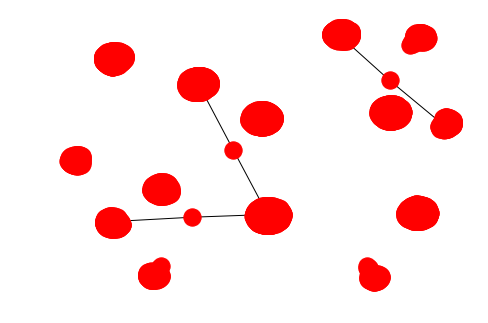

In [36]:
%matplotlib inline
nx.draw(graph)